In [1]:
import numpy as np

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable, default_shape_from_params

import pymc3 as pm

from pymc3.distributions.continuous import assert_negative_support, UnitContinuous
from pymc3.distributions.dist_math import betaln, bound, normal_lcdf
from pymc3.distributions.distribution import Continuous

from pymc3.distributions import transforms

from pymc3.aesaraf import floatX, intX

# a bunch of imports for testing and printing

from aesara.tensor.basic import get_vector_length
from aesara.tensor.random.utils import params_broadcast_shapes
from aesara.tensor.shape import shape_tuple

import aesara

import matplotlib.pyplot as plt
import scipy.stats as st

%config InlineBackend.figure_format = "retina"
%matplotlib inline

print(f"PyMC3 version: {pm.__version__}")
print(f"Aesara version: {aesara.__version__}")

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


PyMC3 version: 4.0
Aesara version: 2.2.1


In [2]:
M = 2.75; K = 19

In [3]:
def stick_glueing(weights):
    shape = tuple(weights.shape or ())
    
    denominator = np.cumsum(
        np.concatenate(
            [
                np.ones(shape=shape[:-1] + (1,)),
                - weights,
            ],
            axis=-1,
        ),
        axis=-1,
    )
    
    output = (weights/(denominator[..., :-1]))
    
    return output[..., :-1]

## `StickBreakingWeightsRV`

In [4]:
class StickBreakingWeightsRV(RandomVariable):
    name = "stick_breaking_weights"
    ndim_supp = 1
    ndims_params = [0, 0]
    dtype = "floatX"
    _print_name = ("StickBreakingWeights", "\\operatorname{StickBreakingWeights}")
    
    def _shape_from_params(self, dist_params, **kwargs):
        # [dist_params[1]] seems to work too... to be revisited with Ricardo soon
        return [dist_params[1] + 1]
    
    def __call__(self, alpha=1., K=10, size=None, **kwargs):
        return super().__call__(alpha, K, size=size, **kwargs)

    @classmethod
    def rng_fn(cls, rng, alpha, K, size):
        size = tuple(size or ()) + (K,)
        
        betas = rng.beta(1, alpha, size=size)
        
        sticks = np.concatenate(
            (
                np.ones(shape=(size[:-1] + (1,))),
                np.cumprod(1 - betas[..., :-1], axis=-1),
            ),
            axis=-1,
        )
        
        weights = sticks * betas
        weights = np.concatenate(
            (
                weights,
                1 - weights.sum(axis=-1)[..., np.newaxis]
            ),
            axis=-1,
        )

        return weights
    

stickbreakingweights = StickBreakingWeightsRV()

## Testing `rng_fn`

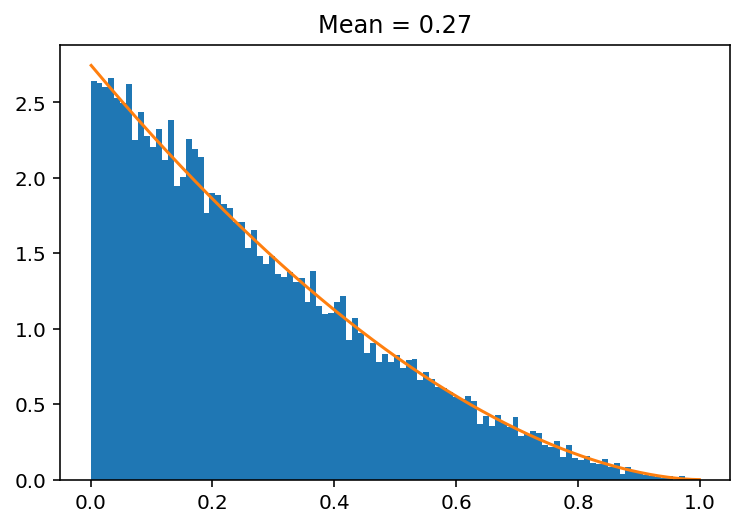

In [5]:
rng = np.random.RandomState(seed=34)
beta_draws = stick_glueing(stickbreakingweights(alpha=M, K=K, size=[1000,]).eval()).reshape(-1,)

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = plt.hist(beta_draws, bins=100, density=True)
_ = plt.plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M)
)
_ = plt.title(f"Mean = {np.around(beta_draws.mean(), 2)}")

In [6]:
class StickBreakingWeights(Continuous):
    rv_op = stickbreakingweights
    
    def __new__(cls, name, *args, **kwargs):
        kwargs.setdefault("transform", transforms.stick_breaking)
        return super().__new__(cls, name, *args, **kwargs)

    @classmethod
    def dist(cls, alpha, K, *args, **kwargs):
        alpha = at.as_tensor_variable(floatX(alpha))
        K = at.as_tensor_variable(K)

        assert_negative_support(alpha, "alpha", "StickBreakingWeights")
        assert_negative_support(K, "K", "StickBreakingWeights")

        return super().dist([alpha, K], **kwargs)

    def logp(value, alpha, K):
        logp = -at.sum(
            at.log(
                at.cumsum(
                    value[..., ::-1],
                    axis=-1,
                )
            ),
            axis=-1,
        )
        logp -= -K * betaln(1, alpha)
        logp += alpha * at.log(value[..., -1])

        return bound(
            logp,
            alpha > 0,
            at.all(value >= 0),
            at.all(value <= 1),
        )

In [7]:
test_point = stickbreakingweights(alpha=M, K=K).eval()

In [8]:
with pm.Model(rng_seeder=rng) as model:
    sbw = StickBreakingWeights(name="sbw", alpha=M, K=K)
    prior = pm.sample_prior_predictive(samples=5000,)
    trace = pm.sample(draws=5000, chains=1, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sbw]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 47 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


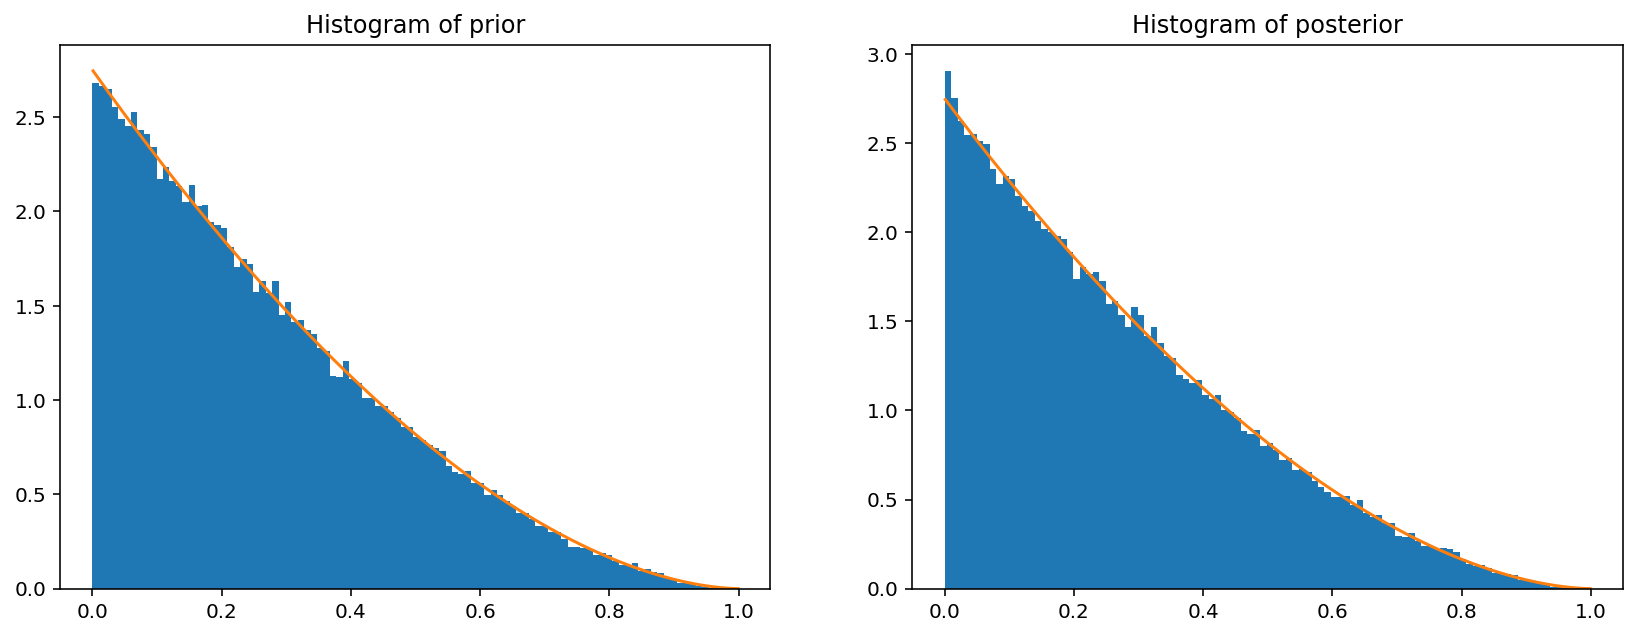

In [9]:
prior_beta_draws = stick_glueing(prior["sbw"]).reshape(-1,)
post_beta_draws = stick_glueing(trace.to_dict()["posterior"]["sbw"][0]).reshape(-1,)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

x_plot = np.linspace(start=0.001, stop=0.999, num=10001)

_ = axes[0].hist(prior_beta_draws, bins=100, density=True)
_ = axes[0].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[0].set_title("Histogram of prior", fontsize=12)

_ = axes[1].hist(post_beta_draws, bins=100, density=True)
_ = axes[1].plot(
    x_plot,
    st.beta.pdf(x_plot, a=1., b=M),
)
_ = axes[1].set_title("Histogram of posterior", fontsize=12)

## Testing the equivalence between `pm.sample_prior_predictive` and `pm.sample` without any observations

In [10]:
with pm.Model() as model:
    norm = pm.Normal("norm", mu=2., sigma=2.)
    prior_norm = pm.sample_prior_predictive(samples=10000,)
    trace_norm = pm.sample(draws=10000, chains=1,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [norm]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


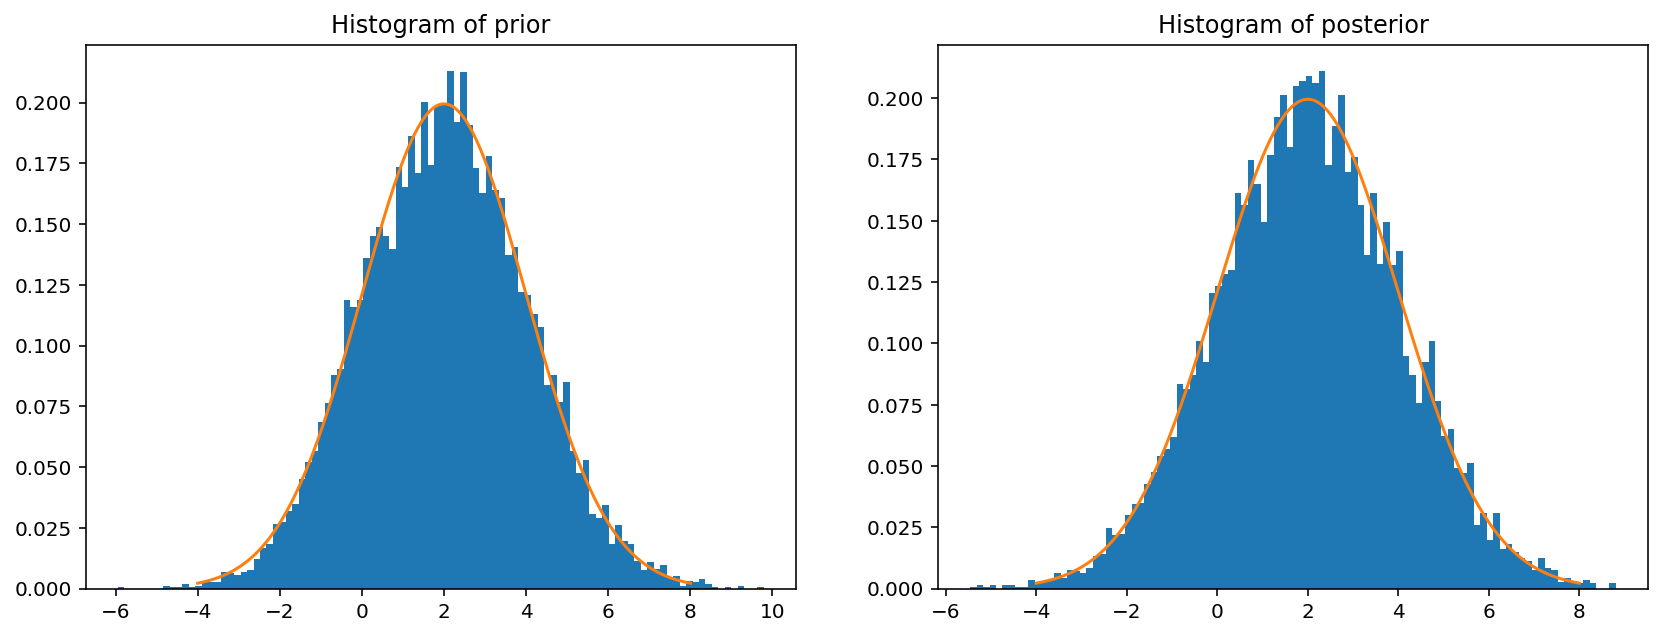

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

x_norm_plot = np.linspace(-4, 8, num=10001,)

_ = axes[0].hist(prior_norm["norm"], bins=100, density=True)
_ = axes[0].plot(x_norm_plot, st.norm.pdf(x_norm_plot, 2, 2))
_ = axes[0].set_title("Histogram of prior", fontsize=12)

_ = axes[1].hist(trace_norm.to_dict()["posterior"]["norm"][0], bins=100, density=True)
_ = axes[1].plot(
    x_norm_plot,
    st.norm.pdf(x_norm_plot, 2, 2),
)
_ = axes[1].set_title("Histogram of posterior", fontsize=12)

## Testing

In [ ]:
pm.DirichletMultinomial.dist(n=2, a=np.array([])

In [61]:
dm_draws = pm.DirichletMultinomial.dist(
    n=np.array([5, 100]),
    a=np.array([[0.001, 0.001, 0.001, 1000], [1000, 1000, 0.001, 0.001]]),
    size=(2, 3),
).eval()

In [69]:
dm_draws.sum(-2)

array([[[46, 54,  0,  5],
        [40, 60,  0,  5],
        [36, 64,  0,  5]],

       [[43, 57,  0,  5],
        [51, 49,  0,  5],
        [41, 59,  0,  5]]])

In [81]:
draws = StickBreakingWeights.dist(
    alpha=0.3,
    K=19,
    size=(47, 53),
).eval()

In [82]:
draws.shape

(47, 53, 20)

In [83]:
draws.mean(0)

array([[8.02120113e-01, 1.48507787e-01, 3.36354160e-02, ...,
        6.51106675e-18, 3.84609631e-18, 3.30704731e-17],
       [7.67374098e-01, 1.80840783e-01, 4.04767088e-02, ...,
        2.66004521e-13, 6.64676777e-14, 6.61409461e-17],
       [7.31854283e-01, 1.85416259e-01, 5.73424647e-02, ...,
        5.47815144e-16, 3.16300515e-16, 8.97627126e-17],
       ...,
       [7.42923142e-01, 1.89502542e-01, 4.95621838e-02, ...,
        6.82289390e-15, 1.97813252e-16, 1.88974132e-17],
       [8.16995977e-01, 1.48844512e-01, 2.16910952e-02, ...,
        7.14681065e-16, 6.21152467e-18, 1.18108832e-17],
       [7.79729366e-01, 1.78946828e-01, 3.36792562e-02, ...,
        2.17112085e-13, 8.98715116e-17, 1.41730599e-17]])